# Initialization

In [1]:
from fnmatch import filter
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, dates, lines
import numpy as np
import datetime as dt
import spacepy.pycdf as cdf
import spacepy.toolbox as tb
import bisect as bi
import seaborn as sns
import os
from scipy.integrate import simps
import scipy.constants as c
from multilabel import multilabel

In [2]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('muted', color_codes=True)
rc('text', usetex=True)
rc('font', family='Mono')
rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']

# Code

## Input

In [3]:
# spe = 'H'
# start = dt.datetime(2013, 7, 11, 13, 0)
# stop = dt.datetime(2013, 7, 11, 16, 0)
# craft = 'A'

# spe = 'H'
# start = dt.datetime(2013, 10, 10, 0, 0)
# stop = dt.datetime(2013, 10, 10, 3, 0)
# craft = 'B'

spe = 'H'
start = dt.datetime(2013, 7, 6, 11, 0)
stop = dt.datetime(2013, 7, 6, 14, 0)
craft = 'B'

# spe = 'H'
# start = dt.datetime(2013, 7, 6, 2, 0)
# stop = dt.datetime(2013, 7, 6, 5, 0)
# craft = 'B'

# spe = 'H'
# start = dt.datetime(2014, 2, 20, 4, 0)
# stop = dt.datetime(2014, 2, 20, 7, 0)
# craft = 'B'

# spe = 'H'
# start = dt.datetime(2014, 2, 15, 9, 0)
# stop = dt.datetime(2014, 2, 15, 12, 0)
# craft = 'A'

# spe = 'H'
# start = dt.datetime(2014, 2, 10, 9, 0)
# stop = dt.datetime(2014, 2, 10, 12, 0)
# craft = 'B'

## Processing

In [4]:
#Load data from RBSPICE

if spe == 'H':
    sp = 'P'
else:
    sp = spe

Hpath = r'C:\Users\Rjc12\WorkSchool\Work\CDFs'+'\\'+craft+r'\TOFxE'+spe+'\\'
Hfname = filter(os.listdir(Hpath), '*'+start.strftime('%Y%m%d')+'*')[-1]

Hcdf = cdf.CDF(Hpath+Hfname)
epoch = Hcdf['Epoch'][...]
Flux = Hcdf['F'+sp+'DU'][...]*(6.242e12)*10000
Energies = Hcdf['F'+sp+'DU_Energy'][...]*(1.60218e-13)
L = Hcdf['L'][...]
MLT = Hcdf['MLT'][...]
PAs = np.radians(Hcdf['PA_Midpoint'][...])
Hcdf.close()

for dater in [start + dt.timedelta(days=x) for x in range(1, (stop.day-start.day)+1)]:

    Hpath = r'C:\Users\Rjc12\WorkSchool\Work\CDFs'+'\\'+craft+r'\TOFxEH\\'
    Hfname = filter(os.listdir(Hpath), '*'+dater.strftime('%Y%m%d')+'*')[0]

    Hcdf = cdf.CDF(Hpath+Hfname)

    epoch = np.append(epoch, Hcdf['Epoch'][...])
    Flux = np.append(Flux, Hcdf['F'+sp+'DU'][...]*(6.242e12)*10000, axis=0)
    L = np.append(L, Hcdf['L'][...])
    MLT = np.append(MLT, Hcdf['MLT'][...])

    Hcdf.close()

In [5]:
#Load data from HOPE

Hopath = r'C:\Users\Rjc12\WorkSchool\Work\CDFs'+'\\'+craft+r'\HOPE\\'
Hofname = filter(os.listdir(Hopath), '*'+start.strftime('%Y%m%d')+'*')[-1]

Hocdf = cdf.CDF(Hopath+Hofname)
Hoepoch = Hocdf['Epoch_Ion'][...]
HoFlux = Hocdf['F'+sp+'DU'][...]*(6.242e15)*10000
HoEnergies = Hocdf['HOPE_ENERGY_Ion'][...]
HoPAs = np.radians(Hocdf['PITCH_ANGLE'][...])
Hocdf.close()

for dater in [start + dt.timedelta(days=x) for x in range(1, (stop.day-start.day)+1)]:

    Hopath = r'C:\Users\Rjc12\WorkSchool\Work\CDFs'+'\\'+craft+r'\HOPE\\'
    Hofname = filter(os.listdir(Hopath), '*'+dater.strftime('%Y%m%d')+'*')[0]

    Hocdf = cdf.CDF(Hopath+Hofname)

    Hoepoch = np.append(Hoepoch, Hocdf['Epoch_Ion'][...])
    HoFlux = np.append(HoFlux, Hocdf['F'+sp+'DU'][...]*(6.242e15)*10000, axis=0)

    Hocdf.close()

In [6]:
#Load data from EMFISIS

Bpath = r'C:\Users\Rjc12\WorkSchool\Work\CDFs'+'\\'+craft+r'\EMFISIS'+'\\'
Bfname = filter(os.listdir(Bpath), '*'+start.strftime('%Y%m%d')+'*')[-1]

Bcdf = cdf.CDF(Bpath+Bfname)
Bepoch = Bcdf['Epoch'][...]
Bmag = Bcdf['Magnitude'][...]
Binvalid = Bcdf['magInvalid'][...]

Bcdf.close()

for dater in [start + dt.timedelta(days=x) for x in range(1, (stop.day-start.day)+1)]:

    Bpath = r'C:\Users\Rjc12\WorkSchool\Work\CDFs'+'\\'+craft+r'\EMFISIS\\'
    Bfname = filter(os.listdir(Bpath), '*'+dater.strftime('%Y%m%d')+'*')[0]

    Bcdf = cdf.CDF(Bpath+Bfname)

    Bepoch = np.append(Bepoch, Bcdf['Epoch'][...])
    Bmag = np.append(Bmag, Bcdf['Magnitude'][...])

    Bcdf.close()

In [7]:
#Get array indices that match time window

fidx = bi.bisect_left(epoch, start)
lidx = bi.bisect_left(epoch, stop)

Hofidx = bi.bisect_left(Hoepoch, start)
Holidx = bi.bisect_left(Hoepoch, stop)

Bfidx = bi.bisect(Bepoch, start)
Blidx = bi.bisect(Bepoch, stop)

#Make sure that B is valid

if np.any(Binvalid[Bfidx:Blidx]):
    raise ValueError('Bmag is not valid for this time period!')
    
#Make sure HOPE energy bins don't change in the time window    

if np.any(HoEnergies[Hofidx:Holidx,:] != HoEnergies[Hofidx,:]):
    raise ValueError('HOPE energies change!')
else:
    HoEnergies = HoEnergies[Hofidx,:]

In [8]:
#Discard low energies from HOPE

LowEidx = bi.bisect(HoEnergies, 300)
HoFlux = HoFlux[:,:,LowEidx:]
HoEnergies = HoEnergies[LowEidx:]*(1.60218e-19)

In [9]:
#Convert datetimes into a format that simps can use (seconds since the epoch)

epsec = [(ep-dt.datetime(1970,1,1)).total_seconds() for ep in epoch[fidx:lidx]]
Hoepsec = [(ep-dt.datetime(1970,1,1)).total_seconds() for ep in Hoepoch[Hofidx:Holidx]]
Bepsec = [(ep-dt.datetime(1970,1,1)).total_seconds() for ep in Bepoch[Bfidx:Blidx]]

In [10]:
#Replace bad data with the nearest valid data (going backwards in time)

for i in range(len(PAs)):
    for j in range(len(Energies)):
        bads = []
        for k in range(fidx, lidx):
            if Flux[k,j,i]<0 or np.isnan(Flux[k,j,i]):
                for l in range(1, k+2):
                    if l == k+1:
                        Flux[k,j,i] = 0
                    if l in bads:
                        continue
                    if Flux[k-l,j,i] >= 0:
                        Flux[k,j,i] = Flux[k-l, j, i]
                        break
                    bads.append(l)
                
for j in range(len(HoPAs)):
    for i in range(len(HoEnergies)):
        bads = []
        for k in range(Hofidx, Holidx):
            if HoFlux[k,j,i]<0 or np.isnan(HoFlux[k,j,i]):
                for l in range(1, k+2):
                    if l == k+1:
                        HoFlux[k,j,i] = 0
                    if l in bads:
                        continue
                    if HoFlux[k-l, j,i] >= 0:
                        HoFlux[k,j,i] = HoFlux[k-l, j, i]
                        break
                    bads.append(l)

In [11]:
#Resample B so that it matches RBSPICE samples

Binter = np.interp(epsec, Bepsec, Bmag[Bfidx:Blidx])
Bpres = ((Binter*c.nano)**2)/(2*c.mu_0)

In [12]:
#Calculate Beta/eV

if spe == 'H':
    m = c.m_p
elif spe == 'He':
    m = 4*c.m_p
elif spe == 'O':
    m = 16*c.m_p
    
TBeta = np.zeros((len(Energies), len(PAs)))

#First integrate over the time window while dividing by B

for i in range(len(Energies)):
    for j in range(len(PAs)):
        TBeta[i,j] = simps(Flux[fidx:lidx,i,j]/Bpres, x=epsec)
    
Betaperp = np.zeros(len(Energies))
Betapara = np.zeros(len(Energies))

#Integrate over the PAs to get Beta/eV, perpendicular and parallel

for i, E in enumerate(Energies):
    Betaperptemp = np.zeros(len(PAs))
    
    for j, PA in enumerate(PAs):
        Betaperptemp[j] = np.pi*np.sqrt(2*m*E)*(np.sin(PA)**3)*TBeta[i,j]
        
    Betaperp[i] = simps(Betaperptemp, x=PAs)
    
for i, E in enumerate(Energies):
    Betaparatemp = np.zeros(len(PAs))
    
    for j, PA in enumerate(PAs):
        Betaparatemp[j] = 2*np.pi*np.sqrt(2*m*E)*(np.sin(PA)*np.cos(PA)**2)*TBeta[i,j]
        
    Betapara[i] = simps(Betaperptemp, x=PAs)

In [13]:
#Calculate total Beta/eV

Beta = (1/3)*(Betapara+2*Betaperp)

In [14]:
#Calculate Beta/eV from HOPE in the same manner

HoBinter = np.interp(Hoepsec, Bepsec, Bmag[Bfidx:Blidx])
HoBpres = ((HoBinter*c.nano)**2)/(2*c.mu_0)

In [15]:
THoBeta = np.zeros((len(HoPAs), len(HoEnergies)))

for i in range(len(HoPAs)):
    for j in range(len(HoEnergies)):
        THoBeta[i,j] = simps(HoFlux[Hofidx:Holidx,i,j]/HoBpres, x=Hoepsec)
    
HoBetaperp = np.zeros(len(HoEnergies))
HoBetapara = np.zeros(len(HoEnergies))

for i, E in enumerate(HoEnergies):
    HoBetaperptemp = np.zeros(len(HoPAs))
    
    for j, PA in enumerate(HoPAs):
        HoBetaperptemp[j] = np.pi*np.sqrt(2*m*E)*(np.sin(PA)**3)*THoBeta[j,i]
        
    HoBetaperp[i] = simps(HoBetaperptemp, x=HoPAs)
    
for i, E in enumerate(HoEnergies):
    HoBetaparatemp = np.zeros(len(HoPAs))
    
    for j, PA in enumerate(HoPAs):
        HoBetaparatemp[j] = 2*np.pi*np.sqrt(2*m*E)*(np.sin(PA)*np.cos(PA)**2)*THoBeta[j,i]
        
    HoBetapara[i] = simps(HoBetaperptemp, x=HoPAs)

In [16]:
HoBeta = (1/3)*(HoBetapara+2*HoBetaperp)

In [17]:
#Calculate Beta from first energy bin up to x-th energy bin
#use even='first', so that simpsons rule is always used on the last interval, which is changing

BetaCDF = []
OBetaCDF = []
TBeta = np.append(HoBeta, Beta[1:])
TEnergies = np.append(HoEnergies, Energies[1:])
for x in range(2, len(TEnergies)):
    BetaCDF = np.append(BetaCDF, simps(TBeta[:x], x=TEnergies[:x], even='first'))
for x in range(2, len(Energies)):
    OBetaCDF = np.append(OBetaCDF, simps(Beta[:x], x=Energies[:x], even='first'))

In [18]:
#Average HOPE flux to smooth zig-zags

HosBeta = [HoBeta[0]]
for i in range(len(HoBeta)-2):
    HosBeta = np.append(HosBeta, np.average([HoBeta[i], HoBeta[i+1]]))
HosBeta = np.append(HosBeta, HoBeta[-1])

## Plotting

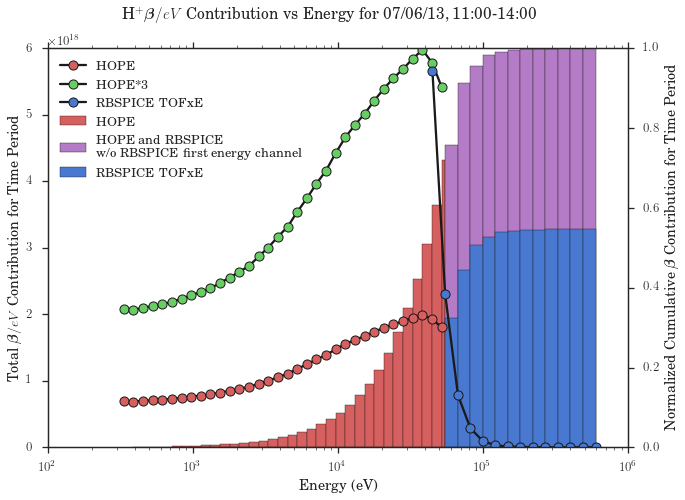

In [19]:
plt.close('all')

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.semilogx(HoEnergies*(6.242e18), HosBeta, 'k', label='HOPE', marker='o', markerfacecolor='r', markeredgewidth=1)
ax.semilogx(HoEnergies*(6.242e18), HosBeta*3, 'k', label='HOPE*3', marker='o', markerfacecolor='g', markeredgewidth=1)
ax.semilogx(Energies*(6.242e18), Beta, 'k', label='RBSPICE TOFxE', marker='o', markerfacecolor='b', markeredgewidth=1)

Width = np.diff(TEnergies*(6.242e18))

NBetaCDF = BetaCDF/np.amax(BetaCDF)
NOBetaCDF = OBetaCDF/np.amax(BetaCDF)

Hob = ax2.bar((TEnergies*(6.242e18))[1:len(HoEnergies)], NBetaCDF[:len(HoEnergies)-1], 
              width=Width[1:len(HoEnergies)], color='r', label='HOPE')
RBHob = ax2.bar((TEnergies*(6.242e18))[len(HoEnergies):-1], NBetaCDF[len(HoEnergies)-1:], 
                width=Width[len(HoEnergies):], color='m', label='HOPE and RBSPICE\nw/o RBSPICE first energy channel')

RBb = ax2.bar((Energies*(6.242e18))[1:-1], NOBetaCDF, 
              width=Width[len(HoEnergies):], color='b', label='RBSPICE TOFxE')

Ho = lines.Line2D([], [], color='k', marker='o', markerfacecolor='r', markeredgewidth=1, label='HOPE')
Ho3 = lines.Line2D([], [], color='k', marker='o', markerfacecolor='g', markeredgewidth=1, label='HOPE*3')
RB = lines.Line2D([], [], color='k', marker='o', markerfacecolor='b', markeredgewidth=1, label='RBSPICE TOFxE')

hands = [Ho, Ho3, RB, Hob, RBHob, RBb]
labs = ['HOPE', 'HOPE*3', 'RBSPICE TOFxE', 'HOPE', 'HOPE and RBSPICE\nw/o RBSPICE first energy channel', 'RBSPICE TOFxE']

ax.legend(hands, labs, loc=2)
ax.set_zorder(2)
ax.patch.set_visible(False)
fig.suptitle(r'H$^+ \boldsymbol{\beta}/eV$ Contribution vs Energy for '+start.strftime('%m/%d/%y, %H:%M-')+stop.strftime('%H:%M'))
ax.set_ylabel(r'Total $\boldsymbol{\beta}/eV$ Contribution for Time Period')
ax2.set_ylabel(r'Normalized Cumulative $\boldsymbol{\beta}$ Contribution for Time Period')
ax.set_xlabel('Energy (eV)')

# plt.savefig(craft+start.strftime('%Y%m%d-%H%M-')+stop.strftime('%H%M-')
#         +'timeIntegrated.png', format='png', dpi=100)

plt.show()

In [20]:
#Create a similar graph, using HOPE*3 for the Beta calculation

BetaCDF = []
OBetaCDF = []
TBeta = np.append(HoBeta*3, Beta[1:])
TEnergies = np.append(HoEnergies, Energies[1:])
for x in range(2, len(TEnergies)):
    BetaCDF = np.append(BetaCDF, simps(TBeta[:x], x=TEnergies[:x], even='first'))
for x in range(2, len(Energies)):
    OBetaCDF = np.append(OBetaCDF, simps(Beta[:x], x=Energies[:x], even='first'))

In [21]:
HosBeta = [HoBeta[0]]
for i in range(len(HoBeta)-2):
    HosBeta = np.append(HosBeta, np.average([HoBeta[i], HoBeta[i+1]]))
HosBeta = np.append(HosBeta, HoBeta[-1])

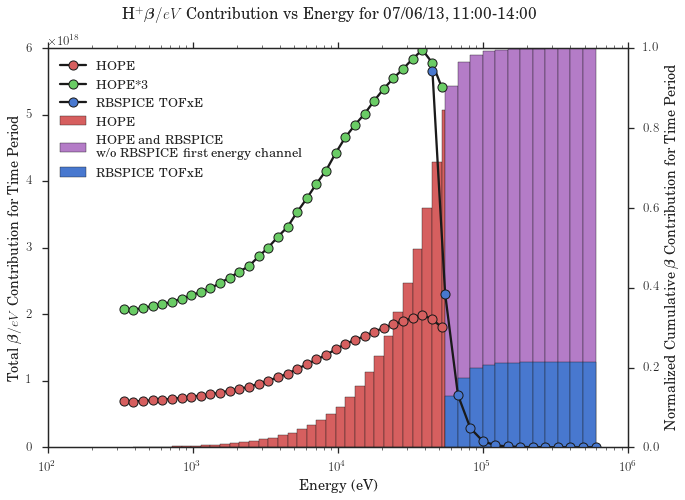

In [22]:
plt.close('all')

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.semilogx(HoEnergies*(6.242e18), HosBeta, 'k', label='HOPE', marker='o', markerfacecolor='r', markeredgewidth=1)
ax.semilogx(HoEnergies*(6.242e18), HosBeta*3, 'k', label='HOPE*3', marker='o', markerfacecolor='g', markeredgewidth=1)
ax.semilogx(Energies*(6.242e18), Beta, 'k', label='RBSPICE TOFxE', marker='o', markerfacecolor='b', markeredgewidth=1)

Width = np.diff(TEnergies*(6.242e18))

NBetaCDF = BetaCDF/np.amax(BetaCDF)
NOBetaCDF = OBetaCDF/np.amax(BetaCDF)

Hob = ax2.bar((TEnergies*(6.242e18))[1:len(HoEnergies)], NBetaCDF[:len(HoEnergies)-1], 
              width=Width[1:len(HoEnergies)], color='r', label='HOPE')
RBHob = ax2.bar((TEnergies*(6.242e18))[len(HoEnergies):-1], NBetaCDF[len(HoEnergies)-1:], 
                width=Width[len(HoEnergies):], color='m', label='HOPE and RBSPICE\nw/o RBSPICE first energy channel')
RBb = ax2.bar((Energies*(6.242e18))[1:-1], NOBetaCDF, 
              width=Width[len(HoEnergies):], color='b', label='RBSPICE TOFxE')

Ho = lines.Line2D([], [], color='k', marker='o', markerfacecolor='r', markeredgewidth=1, label='HOPE')
Ho3 = lines.Line2D([], [], color='k', marker='o', markerfacecolor='g', markeredgewidth=1, label='HOPE*3')
RB = lines.Line2D([], [], color='k', marker='o', markerfacecolor='b', markeredgewidth=1, label='RBSPICE TOFxE')

hands = [Ho, Ho3, RB, Hob, RBHob, RBb]
labs = ['HOPE', 'HOPE*3', 'RBSPICE TOFxE', 'HOPE', 
        'HOPE and RBSPICE\nw/o RBSPICE first energy channel', 'RBSPICE TOFxE']

ax.legend(hands, labs, loc=2)
ax.set_zorder(2)
ax.patch.set_visible(False)
fig.suptitle(r'H$^+ \boldsymbol{\beta}/eV$ Contribution vs Energy for '+start.strftime('%m/%d/%y, %H:%M-')+stop.strftime('%H:%M'))
ax.set_ylabel(r'Total $\boldsymbol{\beta}/eV$ Contribution for Time Period')
ax2.set_ylabel(r'Normalized Cumulative $\boldsymbol{\beta}$ Contribution for Time Period')
ax.set_xlabel('Energy (eV)')

# plt.savefig(craft+start.strftime('%Y%m%d-%H%M-')+stop.strftime('%H%M-')
#         +'timeIntegrated3.png', format='png', dpi=100)

plt.show()